# Random Forest and Adaboost Models

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint, uniform
import warnings

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

## Load Data and Final Preprocessing

In [3]:
data = pd.read_csv("cleaned_data.csv")
data.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,total_sqft,total_sqft15
0,7129300520,221900,3,1.00,1180,5650,1.0,0,0,3,...,98178,47.5112,-122.257,1340,5650,2014,10,13,6830,6990
1,6414100192,538000,3,2.25,2570,7242,2.0,0,0,3,...,98125,47.7210,-122.319,1690,7639,2014,12,9,9812,9329
2,5631500400,180000,2,1.00,770,10000,1.0,0,0,3,...,98028,47.7379,-122.233,2720,8062,2015,2,25,10770,10782
3,2487200875,604000,4,3.00,1960,5000,1.0,0,0,5,...,98136,47.5208,-122.393,1360,5000,2014,12,9,6960,6360
4,1954400510,510000,3,2.00,1680,8080,1.0,0,0,3,...,98074,47.6168,-122.045,1800,7503,2015,2,18,9760,9303


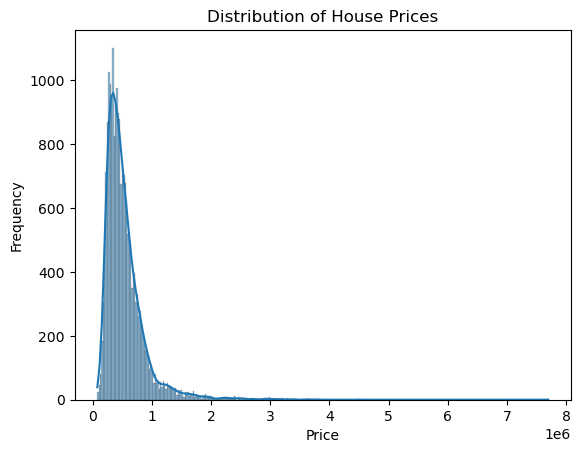

In [4]:
# Analyzing The Target Variable "price"
sns.histplot(data.price, kde=True)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The distribution above is right-skewed which means most prices are in the lower range. A logarithmic transformation to the price will make the distribution closer to normal which usually improves model performance.

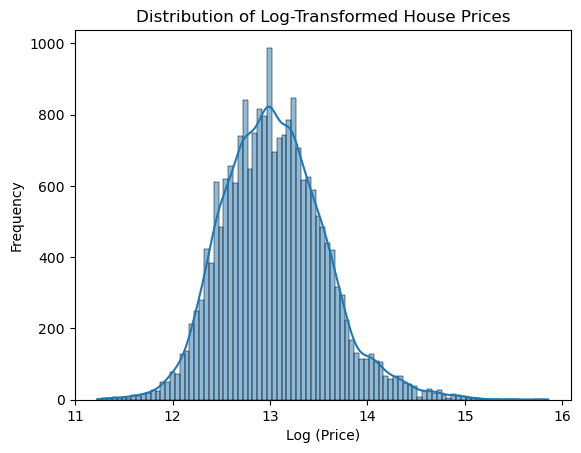

In [5]:
data["log_price"] = np.log(data.price)
sns.histplot(data.log_price, kde=True)
plt.title("Distribution of Log-Transformed House Prices")
plt.xlabel("Log (Price)")
plt.ylabel("Frequency")
plt.show()

In [6]:
data = data.drop(columns=["price","id"])

## Data Split

In [7]:
X = data.drop(columns=["log_price"]) # Features
y = data["log_price"] # Target variable

# Splitting data to training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=371)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((17013, 23), (4254, 23), (17013,), (4254,))

## Models and Analysis

### Random Forest

#### Initial Model

In [8]:
# Training
rf_model = RandomForestRegressor(random_state=371)
rf_model.fit(X_train_scaled, y_train)

# Predicting with the test data
rf_predictions = rf_model.predict(X_test_scaled)

# Evaluating the model
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_predictions)

rf_mae, rf_rmse, rf_r2

(0.12312305499035867, 0.17671109227937595, 0.890049615016481)

The initial random forest model has a strong performance in predicting the price.

1. Mean absolute error (MAE): 0.123
2. Root Mean Squared Error (RMSE): 0.177
3. R²: 0.890

#### Feature Importances

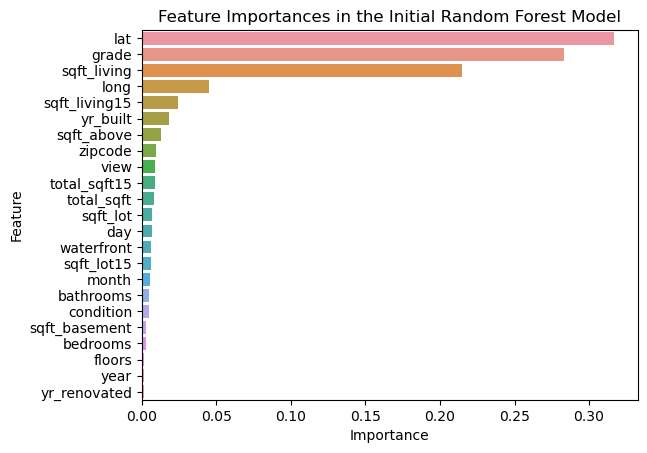

In [9]:
# Finding importances of each feature
feature_importances_rf = pd.DataFrame({
    "feature": X.columns,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Plotting importances
sns.barplot(data=feature_importances_rf, x="importance", y="feature")
plt.title("Feature Importances in the Initial Random Forest Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [10]:
feature_importances_rf

,feature,importance
14,lat,0.316903
8,grade,0.282955
2,sqft_living,0.214522
15,long,0.044940
16,sqft_living15,0.024081
11,yr_built,0.018427
9,sqft_above,0.013043
13,zipcode,0.009671
6,view,0.008746
22,total_sqft15,0.008644


The feature importance analysis of the initial model reveals that the most influential features in predicting price are:

1. "lat" (latitude): 0.317 
2. "grade": 0.283 
3. "sqft_living": 0.215

These features play a significant role in determining house prices, as indicated by their higher importance values in the model.

#### Hyperparameter Tuning

In [16]:
# Parameter distribution
param_dist = {
    "n_estimators": sp_randint(50, 200),
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": sp_randint(2, 11),
    "min_samples_leaf": sp_randint(1, 5)
}

# Randomized Search with Cross-Validation
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=371),
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=2)

# Fit Randomized Search
random_search.fit(X_train_scaled, y_train)

# Best Parameters
best_params_rf = random_search.best_params_
best_params_rf

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 179}

The randomized search with cross-validation searched for the best combination of hyperparameters within specified ranges in the param_dist to find the best hyperparameters, which are:

* "max_depth": 30
* "min_samples_leaf": 2
* "min_samples_split": 7
* "n_estimators": 179

It is expected that these hyperparameters result in a higher predictive performance than the initial model.

#### Model Retraining and Evaluation

In [18]:
# To avoid running the hyperparameter tuning over and over
best_params_rf = {"max_depth": 30, "min_samples_leaf": 2, "min_samples_split": 7, "n_estimators": 179}

# Re-training the model
tuned_model = RandomForestRegressor(**best_params_rf, random_state=371)
tuned_model.fit(X_train_scaled, y_train)

# Predict on the test set
tuned_predictions = tuned_model.predict(X_test_scaled)

# Evaluate the tuned model
tuned_mae = mean_absolute_error(y_test, tuned_predictions)
tuned_rmse = np.sqrt(mean_squared_error(y_test, tuned_predictions))
tuned_r2 = r2_score(y_test, tuned_predictions)

tuned_mae, tuned_rmse, tuned_r2

(0.1225942850853021, 0.17586021218303366, 0.8911059081556776)

In [12]:
mae_difference = tuned_mae - rf_mae
rmse_difference = tuned_rmse - rf_rmse
r2_difference = tuned_r2 - rf_r2

mae_difference, rmse_difference, r2_difference

(-0.0005287699050565697, -0.0008508800963422936, 0.0010562931391965291)

The tuned random forest model shows a **slightly improved performance** compared to the initial model.

* Mean absolute error (MAE): Approximately 0.1226. **Lower by about -0.0005** from initial model.
* Root mean squared error (RMSE): Approximately 0.1759. **Lower by about -0.0009** from initial model.
* R²: Approximately 0.8911. **Higher by about -0.0011** from initial model.

These results indicate the tuned model provides a slightly better fit to the data and improved predictive accuracy compared to the initial model.

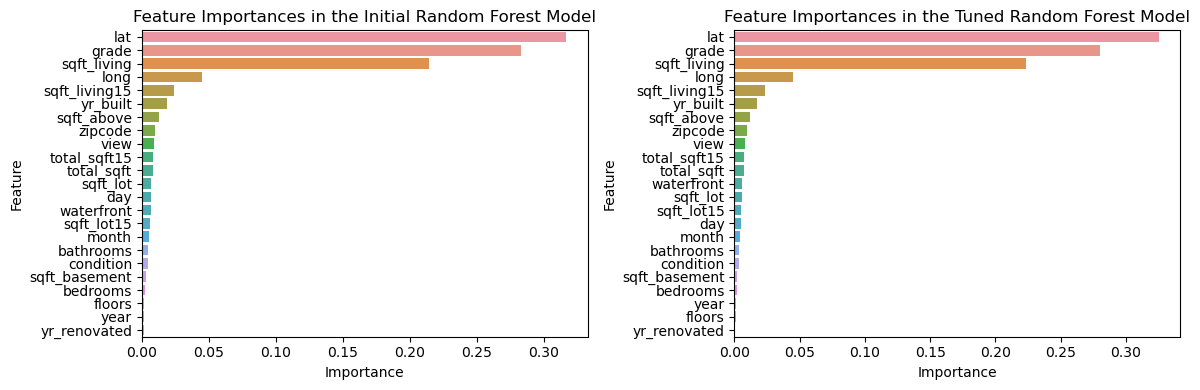

In [13]:
# Feature Importance Analysis
feature_importances_rf_tuned = pd.DataFrame({
    "feature": X.columns,
    "importance": tuned_model.feature_importances_
}).sort_values(by='importance', ascending=False)


# Plotting the Intial and Tuned Model Feature Importances
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(data=feature_importances_rf, x="importance", y="feature", ax=axes[0])
axes[0].set_title("Feature Importances in the Initial Random Forest Model")
axes[0].set_xlabel("Importance")
axes[0].set_ylabel("Feature")

sns.barplot(data=feature_importances_rf_tuned, x="importance", y="feature", ax=axes[1])
axes[1].set_title("Feature Importances in the Tuned Random Forest Model")
axes[1].set_xlabel("Importance")
axes[1].set_ylabel("Feature")

plt.tight_layout()
plt.show()

In [14]:
feature_importances_rf, feature_importances_rf_tuned

(          feature  importance
 14            lat    0.316903
 8           grade    0.282955
 2     sqft_living    0.214522
 15           long    0.044940
 16  sqft_living15    0.024081
 11       yr_built    0.018427
 9      sqft_above    0.013043
 13        zipcode    0.009671
 6            view    0.008746
 22   total_sqft15    0.008644
 21     total_sqft    0.008165
 3        sqft_lot    0.006808
 20            day    0.006559
 5      waterfront    0.006431
 17     sqft_lot15    0.006176
 19          month    0.005606
 1       bathrooms    0.004651
 7       condition    0.004463
 10  sqft_basement    0.002882
 0        bedrooms    0.002577
 4          floors    0.001281
 18           year    0.001259
 12   yr_renovated    0.001210,
           feature  importance
 14            lat    0.325106
 8           grade    0.280245
 2     sqft_living    0.223629
 15           long    0.044551
 16  sqft_living15    0.023167
 11       yr_built    0.017269
 9      sqft_above    0.012307
 13    

In the tuned model, "lat" (latitude) remains the most important feature, followed by "grade" and "sqft_living," with importance values of approximately 0.325, 0.280, and 0.224. Notably, the tuned model slightly increases the importance of "lat" compared to the initial model.

### Adaboost

#### Initial Model

In [15]:
# Training the AdaBoost model
ab_model = AdaBoostRegressor(random_state=42)
ab_model.fit(X_train_scaled, y_train)

# Predicting on the test set
ab_predictions = ab_model.predict(X_test_scaled)

# Evaluating the AdaBoost model
ab_mae = mean_absolute_error(y_test, ab_predictions)
ab_mse = mean_squared_error(y_test, ab_predictions)
ab_rmse = np.sqrt(ab_mse)
ab_r2 = r2_score(y_test, ab_predictions)

ab_mae, ab_rmse, ab_r2

(0.19229571195092432, 0.2492552187731803, 0.7812451694521361)

The initial AdaBoost performace:

1. Mean Absolute Error (MAE): 0.192
2. Root Mean Squared Error (RMSE): 0.249
3. R² (R-squared): 0.781

The AdaBoost model shows reasonable performance, but it has a higher MAE and RMSE compared to the initial random forest models, suggesting the random forest model may initially outperform AdaBoost in this context. Random Forest's are known for its exceptionally high accuracy so this result was expected

#### Feature Importances

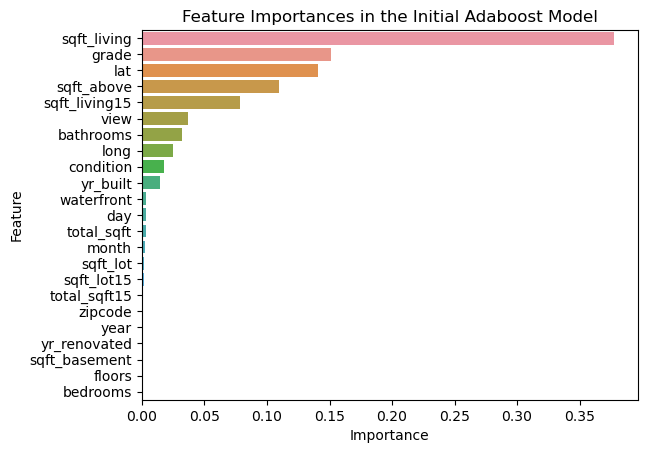

In [16]:
# Analyzing feature importance in the initial Adaboost model
feature_importances_ab = pd.DataFrame({
    "feature": X.columns,
    "importance": ab_model.feature_importances_
}).sort_values(by="importance", ascending=False)

# Plotting the feature importances
sns.barplot(data=feature_importances_ab, x="importance", y="feature")
plt.title("Feature Importances in the Initial Adaboost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [17]:
feature_importances_ab

,feature,importance
2,sqft_living,0.377690
8,grade,0.151061
14,lat,0.140706
9,sqft_above,0.109471
16,sqft_living15,0.078574
6,view,0.036536
1,bathrooms,0.032410
15,long,0.024757
7,condition,0.017330
11,yr_built,0.014084


The initial AdaBoost model's feature importance analysis reveals the importance scores:

1. "sqft_living": 0.378
2. "grade": 0.151
3. "lat": 0.141

"sqft_living" is the most influential predictor, followed by "grade" and "lat." Several features have no importance: "zipcode," "year," "yr_renovated," "sqft_basement," "floors," and "bedrooms" which indicates their limited contribution to predicting house prices in this model.

#### Hyperparameter Tuning

In [47]:
param_dist_ab = {
    "n_estimators": sp_randint(30, 200),
    "learning_rate": uniform(0.01, 1)
}

# Randomized Search with Cross-Validation
random_search_ab = RandomizedSearchCV(estimator=AdaBoostRegressor(random_state=370),
                                      param_distributions=param_dist_ab,
                                      n_iter=10,
                                      cv=5,
                                      n_jobs=-1,
                                      random_state=371,
                                      verbose=2)

random_search_ab.fit(X_train_scaled, y_train)

# Best Parameters
best_params_ab = random_search_ab.best_params_
best_params_ab

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'learning_rate': 0.7059324640867174, 'n_estimators': 44}

Randomized Search with Cross-Validation for hyperparameter tuning of the AdaBoostRegressor found the best parameters:

* Number of Estimators (n_estimators): 44
* Learning Rate (learning_rate): 0.7059

#### Model Retraining and Evaluation

In [20]:
# To avoid running the hyperparameter tuning over and over
best_params_ab = {"learning_rate": 0.7059324640867174, "n_estimators": 44}

# Retrain model
tuned_ab_model = AdaBoostRegressor(**best_params_ab, random_state=371)
tuned_ab_model.fit(X_train_scaled, y_train)

# Predict on the test set
tuned_ab_predictions = tuned_ab_model.predict(X_test_scaled)

# Evaluate the tuned model
tuned_ab_mae = mean_absolute_error(y_test, tuned_ab_predictions)
tuned_ab_rmse = np.sqrt(mean_squared_error(y_test, tuned_ab_predictions))
tuned_ab_r2 = r2_score(y_test, tuned_ab_predictions)

tuned_ab_mae, tuned_ab_rmse, tuned_ab_r2

(0.19772798606561545, 0.2554805785600402, 0.7701815381358825)

In [21]:
mae_difference = tuned_ab_mae - ab_mae
rmse_difference = tuned_ab_rmse - ab_rmse
r2_difference = tuned_ab_r2 - ab_r2

mae_difference, rmse_difference, r2_difference

(0.005432274114691132, 0.0062253597868598964, -0.011063631316253542)

The tuned AdaBoost model shows a **slightly lower performance** compared to the initial model.

* Mean Absolute Error (MAE): Approximately 0.1977. **Higher by about 0.0054** from the initial model.
* Root Mean Squared Error (RMSE): Approximately 0.2555. **Higher by about 0.0067** from the initial model.
* R²: Approximately 0.7702. **Lower by about 0.0110** from the initial model.

These results indicate that the tuned model provides slightly worse predictive performance compared to the initial model.

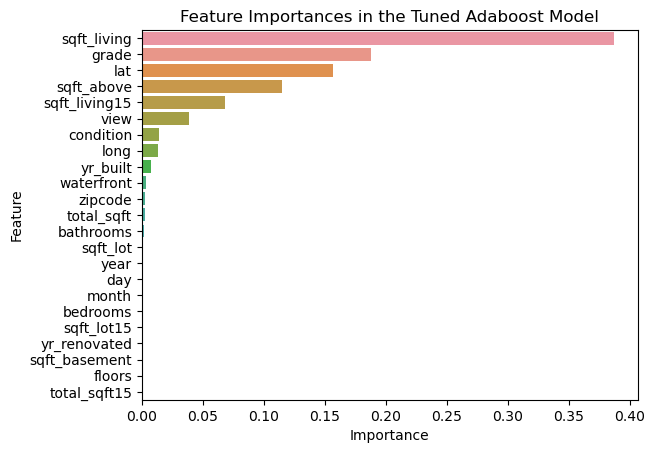

In [22]:
# Feature Importance Analysis
feature_importances_ab_tuned = pd.DataFrame({
    "feature": X.columns,
    'importance': tuned_ab_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Plotting the feature importances
sns.barplot(data=feature_importances_ab_tuned, x="importance", y="feature")
plt.title("Feature Importances in the Tuned Adaboost Model")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [23]:
feature_importances_ab_tuned

,feature,importance
2,sqft_living,0.387388
8,grade,0.187781
14,lat,0.157062
9,sqft_above,0.115159
16,sqft_living15,0.068292
6,view,0.038595
7,condition,0.013655
15,long,0.013346
11,yr_built,0.007731
5,waterfront,0.003517


The tuned AdaBoost model's feature importance differs from the initial AdaBoost feature importance by placing slightly more importance on "sqft_living" and "grade" while reducing the importance of other features.

## Conclusion

Based on the predictive analysis using the Random Forest and AdaBoost models, several key insights emerged. Initially, the Random Forest model displayed strong predictive performance with a high R² value and relatively low errors (MAE and RMSE). Feature importance analysis showed that latitude, grade, and square footage of living space were the top predictors. Hyperparameter tuning further improved the model's accuracy, very a very slim amount. For the AdaBoost model, although it showed reasonable performance, it was outperformed by the Random Forest model. The most influential features in the AdaBoost model were similar to those in the Random Forest model. However, the tuned AdaBoost model did not improve upon the initial model's performance and actually showed a slight decrease in accuracy. Overall, the Random Forest model stands out as the more effective model for predicting house prices in this dataset, demonstrating robustness and accuracy, particularly after hyperparameter tuning. The feature importance analyses in both models highlight key factors influencing housing prices, with location (latitude), property grade, and living area size being the most significant.